# Virtual Pruning

## Importing the digitized structure

In [1]:
from openalea.mtg import *
import numpy as np
from importlib import reload
import mangoG3; reload(mangoG3)
from mangoG3 import *

g = get_G3_mtg()
focus = None #11083
#g = extend_mtg_with_organs(g)

In [2]:
simplification = False

if simplification:
    import simplif ; reload(simplif)
    from simplif import simplify_mtg
    sg = simplify_mtg(g,11083)
    g = sg

In [3]:
from matplotlib.pyplot import *
import mtgplot as mp
reload(mp)

<module 'mtgplot' from '/Users/fboudon/Develop/oagit/virtualpruning/notebooks/mtgplot.py'>

In [4]:
#initrepr = mp.representation(g, wood = True, leaves=True, gc=False)
#initrepr.save('initialtree.bgeom')
sw = mp.plot_tree(g, leaves=True, focus=focus)
sw

SceneWidget(scenes=[{'id': 'HAZaCkhRF5Jc1ydhnwSG7gTin', 'data': b'x\xda\xcc\x9d\x07|\xd3\xd6\xd7\xf7\xc3\x08#l…


# Pruning

In [5]:
import pruning ; reload(pruning)
from pruning import *

In [46]:
prunedmtg = prune(g, 30)

In [47]:
intensity = continuous_intensity_from_pruned(prunedmtg)
print(intensity, intensity_level(intensity))

0.09646876048999044 T1


In [ ]:
# estimer nb de point de coupe vs intensité
# estimer intensité vs gap fraction
# estimer intensité vs surface foliaire retirée (severine ?)

# Mortality post pruning

In [48]:
import mortality ; reload(mortality)
from mortality import gu_mortalities_post_pruning

In [49]:
postpruningmtg, removed = gu_mortalities_post_pruning(prunedmtg, intensity)
print(len(removed))

Should examine 3095  GUs.
200


In [50]:
mp.plot_tree(postpruningmtg, leaves=True, focus=focus) # plot with color for cuts

SceneWidget(scenes=[{'id': 'AvQr7b4VNVtlIq9n8Em9QZspf', 'data': b'x\xda\xcc\x9d\x07|\x14\xc5\xfb\xffC\t%t\x02\…

# Light

In [51]:
import lightestimation; reload(lightestimation)
from lightestimation import *

In [52]:
prunedrepr = mp.representation(postpruningmtg, wood = False, leaves=True)
Zeta_mean = light_variables(prunedrepr, skydiscretization=16)

In [13]:
mp.plot_tree(postpruningmtg,colorizer = mp.PropertyGradientColoring(prop=Zeta_mean, minvalue=0, defaultvalue=0), focus=focus, leaves=True)

SceneWidget(scenes=[{'id': 'D8pnWjrCAHlCRehFz1Ft38tlP', 'data': b'x\xda\xcc\x9d\x07|\x14E\xfb\xf8\xef\x80\xd0[…

<AxesSubplot:>

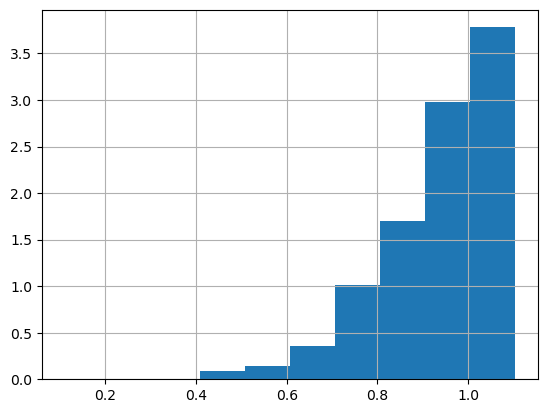

In [14]:
Zeta_mean.hist(density=True)

In [54]:
def myhist(values, bins=10):
    import numpy as np
    from scipy.interpolate import interp1d
    hist, bin_edges = np.histogram(values, density=True,bins=bins)
    print(len(hist))
    print(len(hist),len(bin_edges))
    histx = [bin_edges[0]]+[(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(hist))]+[bin_edges[-1]]
    histy = [hist[0]]+list(hist)+[hist[-1]]
    cubic_interpolation_model = interp1d(histx, histy, kind = "cubic")
    X_=np.linspace(min(histx),max(histx), 500)
    Y_=cubic_interpolation_model(X_)
    fig, ax = subplots()
    ax.plot(X_,Y_)
    verts = [(histx[0], 0), *zip(X_, Y_), (histx[-1], 0)]
    poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
    ax.add_patch(poly)
    show()
    

10
10 11


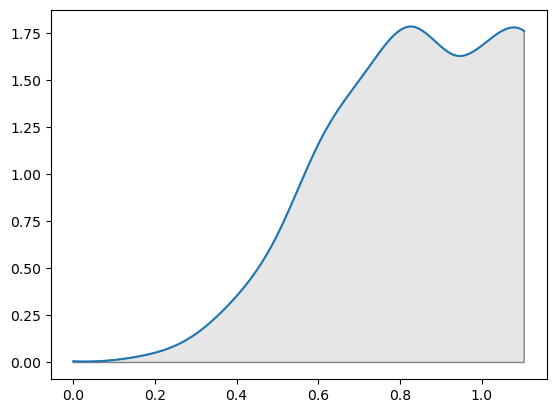

In [53]:
myhist(Zeta_mean)

# Regrowth

In [ ]:
import regrowth_base; reload(regrowth_base)
from regrowth_base import plot_growth
import regrowth; reload(regrowth)
from regrowth import *

In [ ]:
regrowth, newids = growth(postpruningmtg, intensity, Zeta_mean)
print('Created', len(newids), 'new GUs from', len(set([get_parent(regrowth,vid) for vid in newids])),'terminals.')


In [ ]:
plot_growth(regrowth, leaves=True, gc=True)

In [ ]:
def date_histo(g):
    from matplotlib.pyplot import hist, show
    from collections import Counter
    from datetime import timedelta
    c = list(Counter(g.property('BurstDate').values()).items())
    c.sort(key = lambda v : v[0])
    mindate = c[0][0]
    maxdate = c[-1][0]
    c = dict(c)
    r = range(0,(maxdate-mindate).days)
    d = [mindate+timedelta(days=d) for d in r]
    v = [ c.get(di,0) for di in d]
    bar(r,v)
    xticks(r,d, rotation=90)
    show()

In [ ]:
date_histo(regrowth)

In [ ]:
#plot_growth_dynamic(regrowth)

In [ ]:
def nb_children_histo(g):
    def severity(vid):
        return g.property('pruned').get(vid,0)

    ancestors = [get_parent(g,vid) if vid in g.property('BurstDate') else vid for vid in get_all_terminal_gus(g) ]
    ancestors = set(ancestors)
    
    values = [[] for i in range(4)]
    for vid in ancestors:
        values[severity(vid)].append(g.nb_children(vid))
    figure(figsize=(18,8))
    for order, v in enumerate(values):
        if len(v) > 0:
            subplot(220+order+1)
            hist(v, bins=np.arange(0,max(1,max(v)))-0.5)
            print(len(v),(np.mean(v), np.std(v)),(np.mean([vi for vi in v if vi > 0]), np.std([vi for vi in v if vi > 0])),(np.min(v), np.max(v)))
    show()
    

In [ ]:
nb_children_histo(regrowth)

Les **longueurs d'UCs générées** suivent la loi normale du modèle précédent. A corriger avec données 2017

## Gap fraction

In [ ]:
import gapfraction ; reload(gapfraction)
from gapfraction import gapfraction_dynamic, gap_fraction, pgl_gapfraction_dynamic

In [ ]:
gft = pgl_gapfraction_dynamic(regrowth)

In [ ]:
gft = gft[1:]

In [ ]:
pruningdate = date(2021,2,24)
gf0 = gap_fraction(g)

In [ ]:
from matplotlib.pyplot import *
plot([pruningdate,pruningdate]+[d for d,g in gft],[gf0,gft[0][1]]+[g for d,g in gft])
hlines(gf0,pruningdate,gft[-1][0],color='r')
ylim(0,0.5)
xticks(rotation = 80)
show()

# leaf area produced at the tree scale vs. leaf area removed by pruning

In [ ]:
def leaf_area_produced(mtg,newids):
    newids = growth(t3, listidprunedT3, T3)
    totalleafarea = sum([individual_leafarea_unpruned() for vid in newids])
    growth(t3, listidprunedT3, T3)
    return totalleafarea

# améliorations possibles du modèle

In [ ]:
def simulation(mtg, nbcuts, gumortality = True):
    from allometry import gu_leaf_area
    # characterize before pruning
    # nb of terminal units
    nbterminalunits = len(get_all_terminal_gus(mtg))

    # determine pruning
    listidpruned = define_pruning(mtg, nbcuts, None)
    #pruningprop = tag_pruning(mtg, listidpruned)

    # characterize pruning
    # - intensity
    intensity = continuous_intensity(g,listidpruned)
    ilevel = intensity_level(intensity)
    if intensity == T2:
        raise ValueError('Intensity', ilevel, intensity)
        
    #  - nb of terminal units
    nbremovedGU = sum([sum([len(get_descendants_gus_from_ancestor(mtg, vid))-1 for vid in pruneds]) for order, pruneds in listidpruned.items()])
    
    # - surface foliaire retire 
    removed_leaf_area = sum([sum([gu_leaf_area(get_gu_diameter(mtg, vid)) for vid in pruneds]) for order, pruneds in listidpruned.items()])
    
    # apply pruning
    prunedmtg = apply_pruning(mtg, listidpruned)
    
    if gumortality:
        prunedrepr = mp.representation(prunedmtg, wood = False, leaves=True)
        Zeta_min = light_variables_mortality(prunedrepr)
    
        postpruningmtg, removed = gu_mortalities_post_pruning(prunedmtg, Zeta_min, intensity)
        postpruningrepr = mp.representation(postpruningmtg, wood = False, leaves=True)
    else:
        postpruningmtg = prunedmtg
        postpruningrepr = mp.representation(postpruningmtg, wood = False, leaves=True)
        
    
    TrPPFD_mean, TrPPFD_min, Zeta_mean, Zeta_8H = light_variables_regrowth(postpruningrepr)

    
    # apply growth    
    growthmtg, newGUs = growth(postpruningmtg, TrPPFD_mean, TrPPFD_min, Zeta_mean, Zeta_8H, intensity, mortalityenabled=gumortality)


    # characterize pruning
    # nb of terminal units

    allpruned = set(listidpruned.keys())

    # characterize growth
    nbgeneratedGU = len(newGUs)
    generated_leaf_area_pruned = sum([la for vid,la in growthmtg.property('RegeneratedLeafArea').items() if vid in allpruned])
    generated_leaf_area_unpruned = sum([la for vid,la in growthmtg.property('RegeneratedLeafArea').items() if not (vid in allpruned)])
    
    return (nbterminalunits, nbremovedGU, nbgeneratedGU), (removed_leaf_area, generated_leaf_area_pruned, generated_leaf_area_unpruned)
    

In [ ]:
units0, la0 = simulation(g, 0)
print(units0, la0)

In [ ]:
units20, la20 = simulation(g, 15)
print(units20, la20)

In [ ]:
units60, la60 = simulation(g, 60)
print(units60, la60)

In [ ]:
#units0060, la0060 = pipeline(g, (0,30,76))
#print(units0060, la0060)

In [ ]:
print(la0[1]-la0[0])
print(la20[1]-la20[0])
print(la60[1]-la60[0])


In [ ]:
def process_range(mtg, cutrange = (0,20), cuttype = (1,1,1), nbtests = 1):
    if type(cutrange) == int:
        cutrange = (0, cutrange)
    import numpy as np
    gla = []
    gunits = [] 
    cuts = []
    for c in range(*cutrange):
        for i in range(nbtests):
            print('process',c,'-',i)
            try:
                units, la = simulation(mtg, [c*i for i in cuttype])
            except ValueError as e:
                print(e)
                continue
            gla.append(la)
            gunits.append(units)
            cuts.append(c)
    gla = np.array(gla)
    gunits = np.array(gunits)
    return cuts, gla, gunits
    

In [ ]:
cuts76, las76, units76 = process_range(g,(0,180,5), nbtests = 1)


In [ ]:
def plot_cutrange(cuts, las, units):
    figure(figsize=(12,6))
    #subplot(121)
    normalproduction = np.mean(las[np.where(np.isin(cuts,[0]))[0],2])
    plot(cuts,las[:,0],'.',label='removed leaf area')
    plot(cuts,las[:,1],'.',label='generated leaf area from pruned GU')
    plot(cuts,las[:,2],'.',label='generated leaf area from unpruned GU')
    plot(cuts,las[:,1]+las[:,2],'.',label='generated leaf area')
    plot(cuts,(las[:,1]+las[:,2])-(las[:,0]+normalproduction),'.',label='increase of leaf area (compared to To)')
    legend()
    show()
    figure(figsize=(12,6))
    #subplot(122)
    plot(cuts,units[:,0],'.',label='nb terminal units')
    plot(cuts,units[:,1],'.',label='nb removed GU')
    plot(cuts,units[:,2],'.',label='nb generated GU')
    legend()
    show()


In [ ]:
plot_cutrange(cuts76, las76, units76)


In [ ]:

cuts, las, units = process_range(g,(0,300,5), cuttype = (1,0,0), nbtests = 1)

In [ ]:
plot_cutrange(cuts, las, units)

In [ ]:
cuts, las, units = process_range(g,(0,300,5), cuttype = (0,1,0), nbtests = 1)

In [ ]:
plot_cutrange(cuts, las, units)

In [ ]:
cuts, las, units = process_range(g,(0,80,2), cuttype = (0,0,1), nbtests = 1)

In [ ]:
plot_cutrange(cuts, las, units)